## This Notebook is tasked with learning the kernel from some pinhole data. 
#### We do it in two stages. First we apply an affine transform model to get the kernel in the right location. Then we make regions of the kernel trainable and do further training. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os, sys
main_dir = os.path.dirname(os.path.dirname(os.path.abspath('')))
sys.path.insert(0, main_dir)

import models.helper as hlp
from models.custom.model import *
import forward.fourier.method as fwd
from forward.fourier.kernel_creator import *

import gc
def clear_gpu():
    gc.collect()
    torch.cuda.empty_cache()


if torch.cuda.is_available():
    print(torch.cuda.device_count(), "GPU(s) available:")
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))
else:
    print("No GPUs available.")


%load_ext autoreload
%autoreload 2
device = 'cuda:0'



4 GPU(s) available:
NVIDIA A40
NVIDIA A40
NVIDIA A40
NVIDIA A40


In [2]:
kernel = create_fourier_kernel().to(device)

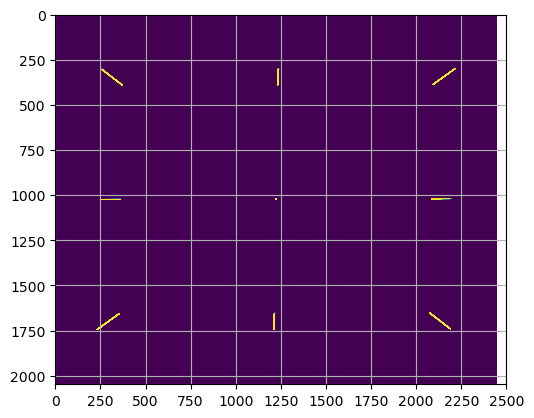

In [3]:
import matplotlib.patches as patch

fig,ax = plt.subplots(1,dpi=100)
ax.imshow(torch.sum((kernel)[0],dim=0).cpu().detach().numpy(),vmax=0.0001)
ax.set_xticks(np.linspace(0,2500,11))

plt.grid()

## Go from nograting cube to grating cube with grad descent


In [4]:


grating_cube, _, _ = hlp.create_bs_data(desired_channels=21,kernel=kernel,fts_dir = '20230628_2gratings_pinhole_data_40000us_talbot_0', cube_dir = '20230628_2gratings_pinhole_analysis_40000us_talbot_0', interp_type='average',device=device)
nograting_cube, _, _ = hlp.create_bs_data(desired_channels=21,kernel=kernel,fts_dir = '20230628_pinhole_data_800us_talbot_0', cube_dir = '20230628_pinhole_analysis_800us_talbot_0', interp_type='average',device=device) 
sx,sy = nograting_cube.shape[2:]

spectra = nograting_cube[0,...,sx//2,sy//2]



collecting the undispersed cube and spectra.
collecting the undispersed cube and spectra.


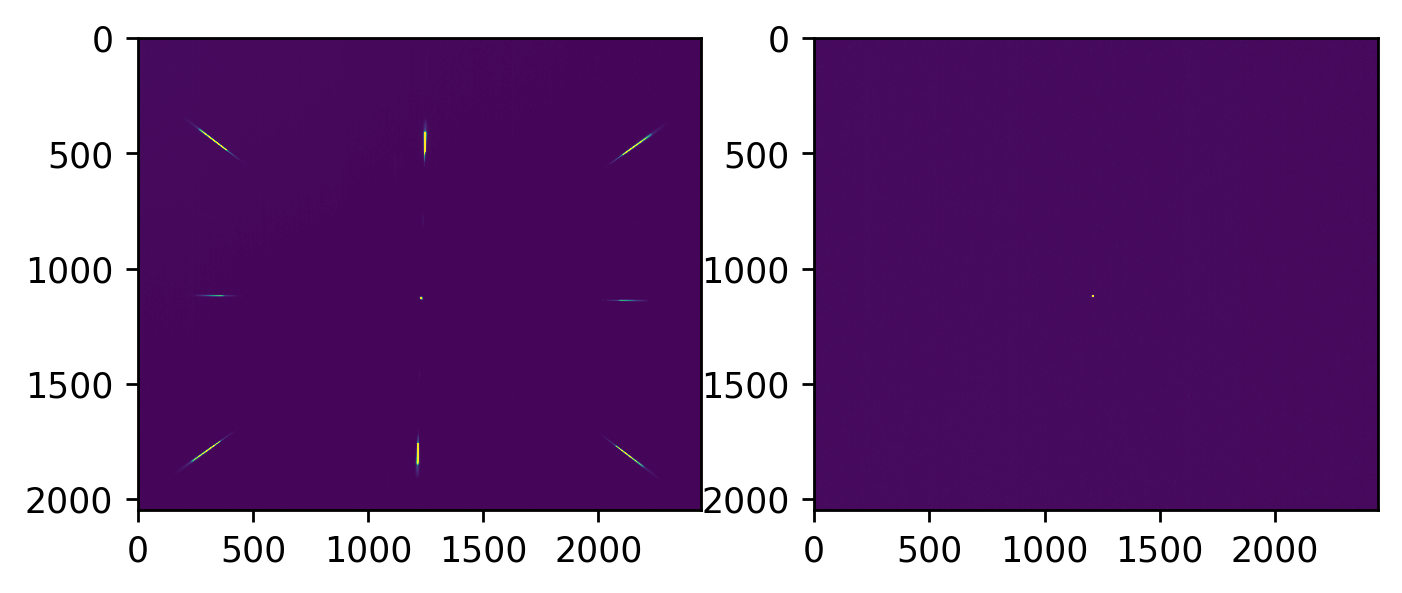

In [5]:
fig,ax = plt.subplots(1,2,dpi=250)

ax[0].imshow(torch.sum(grating_cube[0],dim=0).cpu().numpy(),vmax=0.1)

ax[1].imshow(torch.sum(nograting_cube[0],dim=0).cpu().numpy(),vmax=0.1)

In [6]:
nograting_cube, grating_cube = hlp.center_cubes(nograting_cube, grating_cube)

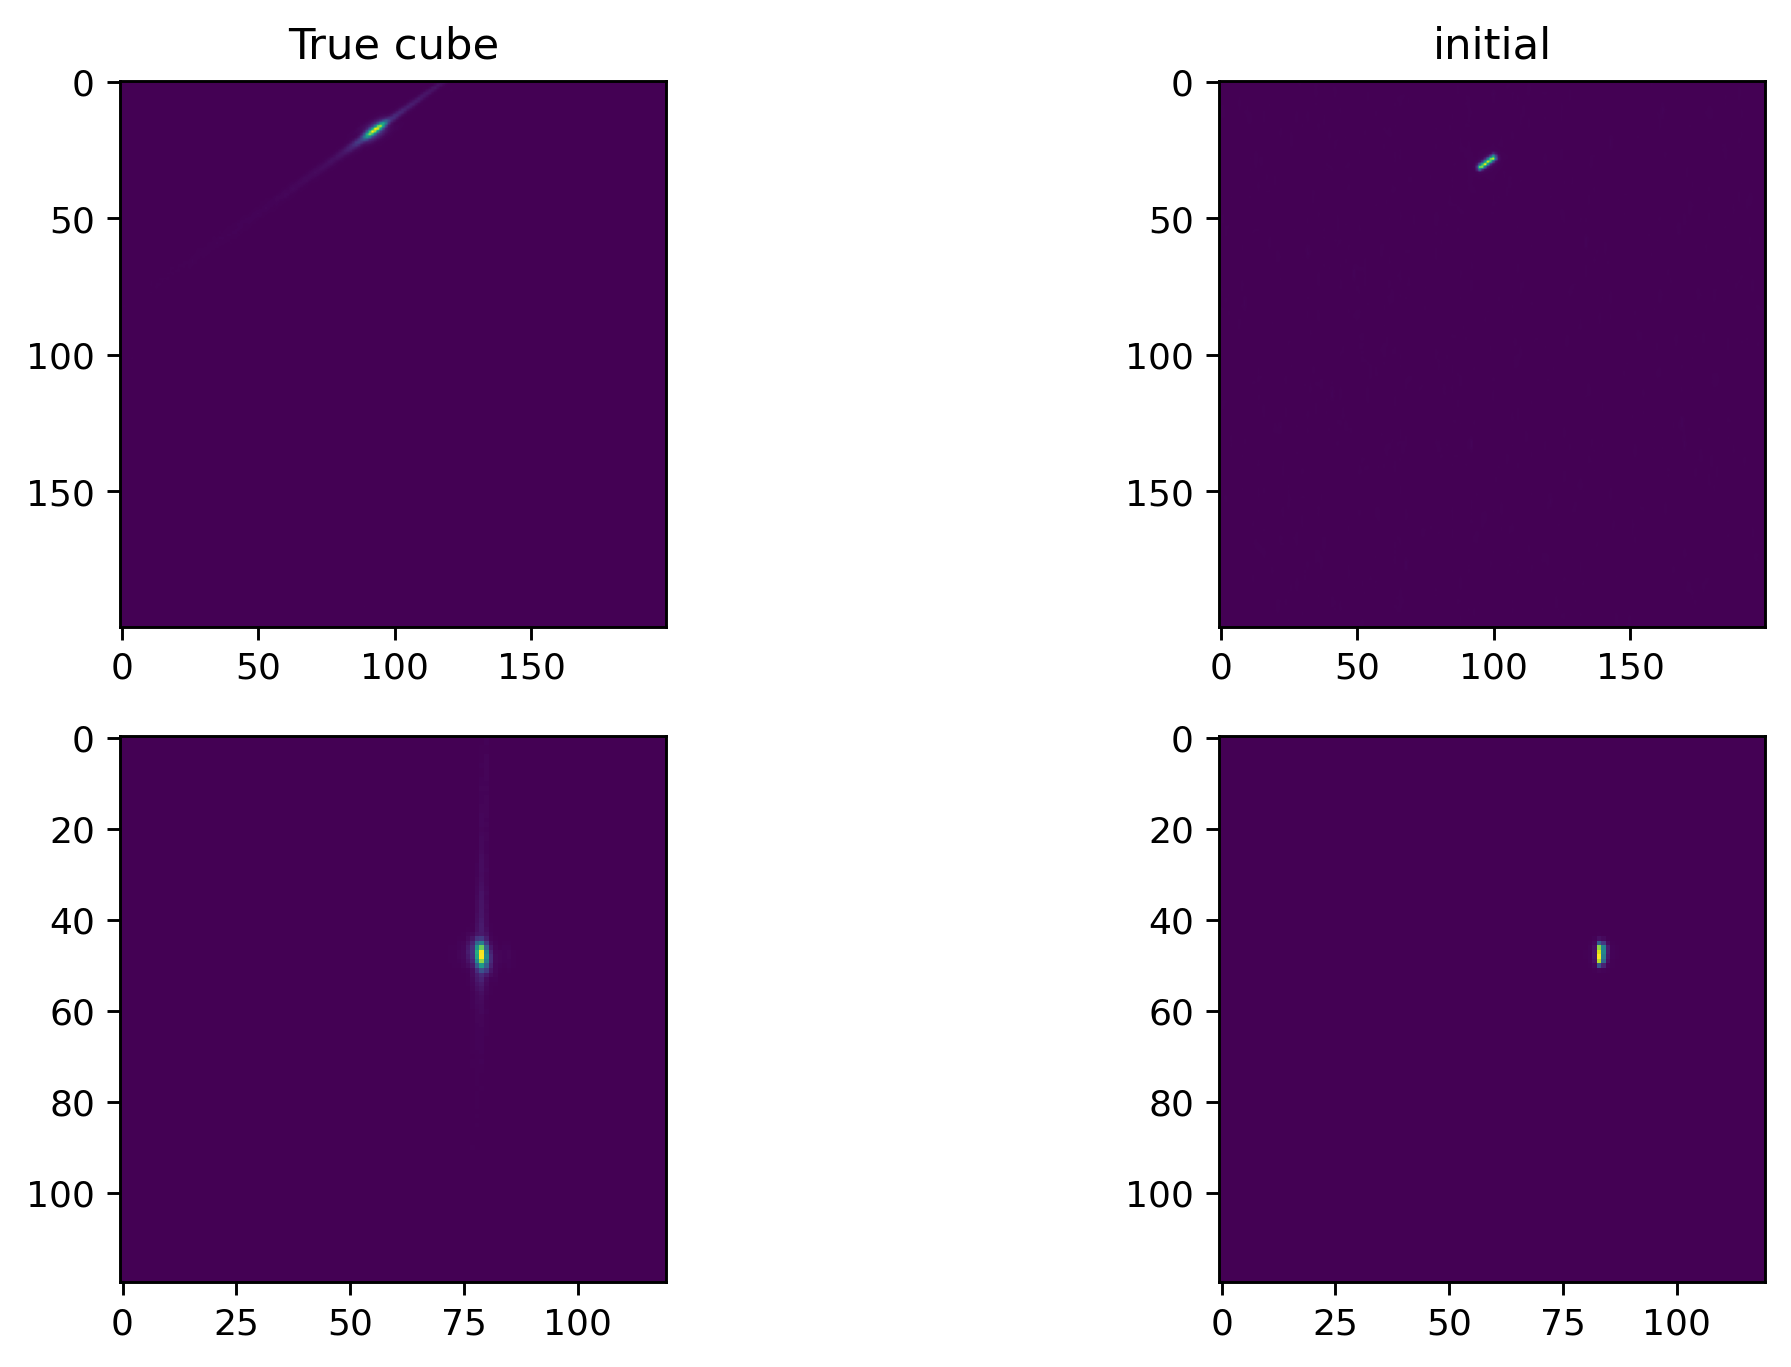

In [7]:
a = [0,21]


init_guess = fwd.disperser.disperse_all_orders(nograting_cube[:,a[0]:a[1]],kernel[:,a[0]:a[1]])
wl = 10

b1,b2 = [1670,1870]
b3,b4 = [200,400]



fig,ax = plt.subplots(2,2,figsize=(10,6),dpi=260)
ax[0,0].set_title('True cube')
ax[0,1].set_title('initial')

ax[0,0].imshow(grating_cube[:,a[0]:a[1]][0,wl,b1:b2,b3:b4].cpu().detach().numpy())
ax[0,1].imshow(init_guess[0,wl,b1:b2,b3:b4].cpu().detach().numpy())

a1,a2 = [1650,1770]
a3,a4 = [1130,1250]

ax[1,0].imshow(grating_cube[:,a[0]:a[1]][0,wl,a1:a2,a3:a4].cpu().detach().numpy())
ax[1,1].imshow(init_guess[0,wl,a1:a2,a3:a4].cpu().detach().numpy())

In [8]:
zeros = torch.zeros_like(nograting_cube)
zeros[0,...,sx//2-5:sx//2+5,sy//2-5:sy//2+5] = nograting_cube[0,...,sx//2-5:sx//2+5,sy//2-5:sy//2+5]
nograting_cube = zeros



### Find a multiplication factor between them?

In [9]:

mult_fac = np.linspace(0.1, 20,1000)

store_loss = np.zeros(1000)

for i in range(1000):

    init_guess = fwd.disperser.disperse_all_orders(nograting_cube[:,a[0]:a[1]],kernel[:,a[0]:a[1]]* mult_fac[i])
    

    store_loss[i] = torch.abs(init_guess.max() - grating_cube.max()).cpu().detach().numpy()

print(np.argmin(store_loss))

print(mult_fac[np.argmin(store_loss)])


# mult_fac = torch.ones(2000)


540
10.856756756756756


In [10]:
pos = findclusters(grating_cube.cpu(),threshold=0.03, padding=150,type='boxes')

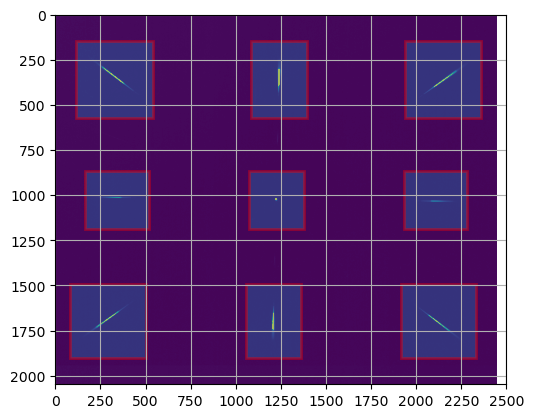

In [15]:
fig,ax = plt.subplots(1,dpi=100)
ax.imshow(torch.sum((grating_cube)[0],dim=0).cpu().detach().numpy(),vmax=0.1)

ax.set_xticks(np.linspace(0,2500,11))

for i in range(9):
    ax.add_patch(patch.Rectangle([pos[i,1,0],pos[i,0,0]],pos[i,1,1] - pos[i,1,0],pos[i,0,1] - pos[i,0,0], facecolor=None, ec='r',alpha=0.4, lw=2))

plt.grid()

In [36]:

scaled_kernel = kernel*mult_fac[np.argmin(store_loss)]
init_guess = fwd.disperser.disperse_all_orders(nograting_cube[:,a[0]:a[1]],scaled_kernel[:,a[0]:a[1]])

lr = 1e-2
epochs = 100



a = [0,21]

loss_fn1 = torch.nn.MSELoss()
loss_fn2 = CenterOfMassLoss(pos, intensity_factor= 3)


loss = loss_fn1(init_guess,grating_cube[:,a[0]:a[1]]) + loss_fn2(init_guess,grating_cube[:,a[0]:a[1]]) * 1e-6
print(loss)

tensor(7.9038e-05, device='cuda:0')


In [37]:

model = AffineTransformModel(region = pos, rot=0., transX=0., transY=0.).to(device)



optimizer = torch.optim.Adam(model.parameters(), lr=lr)



In [38]:
history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['mse'] = []



start_time_sec = time.time()
num_train_examples = 1

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    optimizer.zero_grad()


    affine_kernel = model(scaled_kernel)
    yhat = fwd.disperser.disperse_all_orders(nograting_cube[:,a[0]:a[1]],affine_kernel[:,a[0]:a[1]])

    mse = loss_fn1(yhat, grating_cube[:,a[0]:a[1]])
    
    loss =  mse + loss_fn2(yhat, grating_cube[:,a[0]:a[1]]) * 1e-6


    loss.backward()
    optimizer.step()

    train_loss        = loss.data.item() * grating_cube.size(0)

    train_mse        = mse.data.item() * grating_cube.size(0)
    



    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec
    print(f'Epoch {epoch}/{epochs}: , train loss: {(train_loss/num_train_examples):5.5g}, train mse: {(train_mse/num_train_examples):5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')



    history['loss'].append(train_loss)
    history['mse'].append(train_mse)



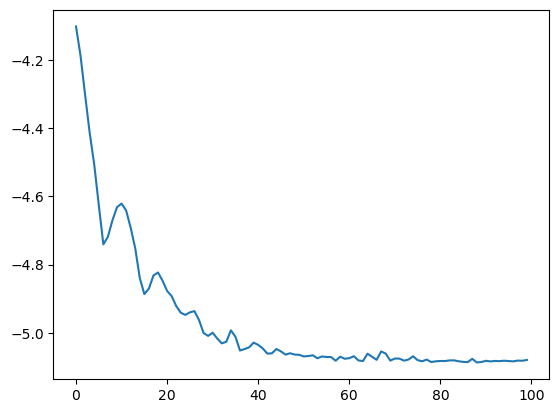

In [39]:
plt.plot(np.log10(history['loss']))

In [40]:
init_guess = fwd.disperser.disperse_all_orders(nograting_cube[:,a[0]:a[1]],kernel[:,a[0]:a[1]])


Text(0.5, 1.0, 'Trained guess')

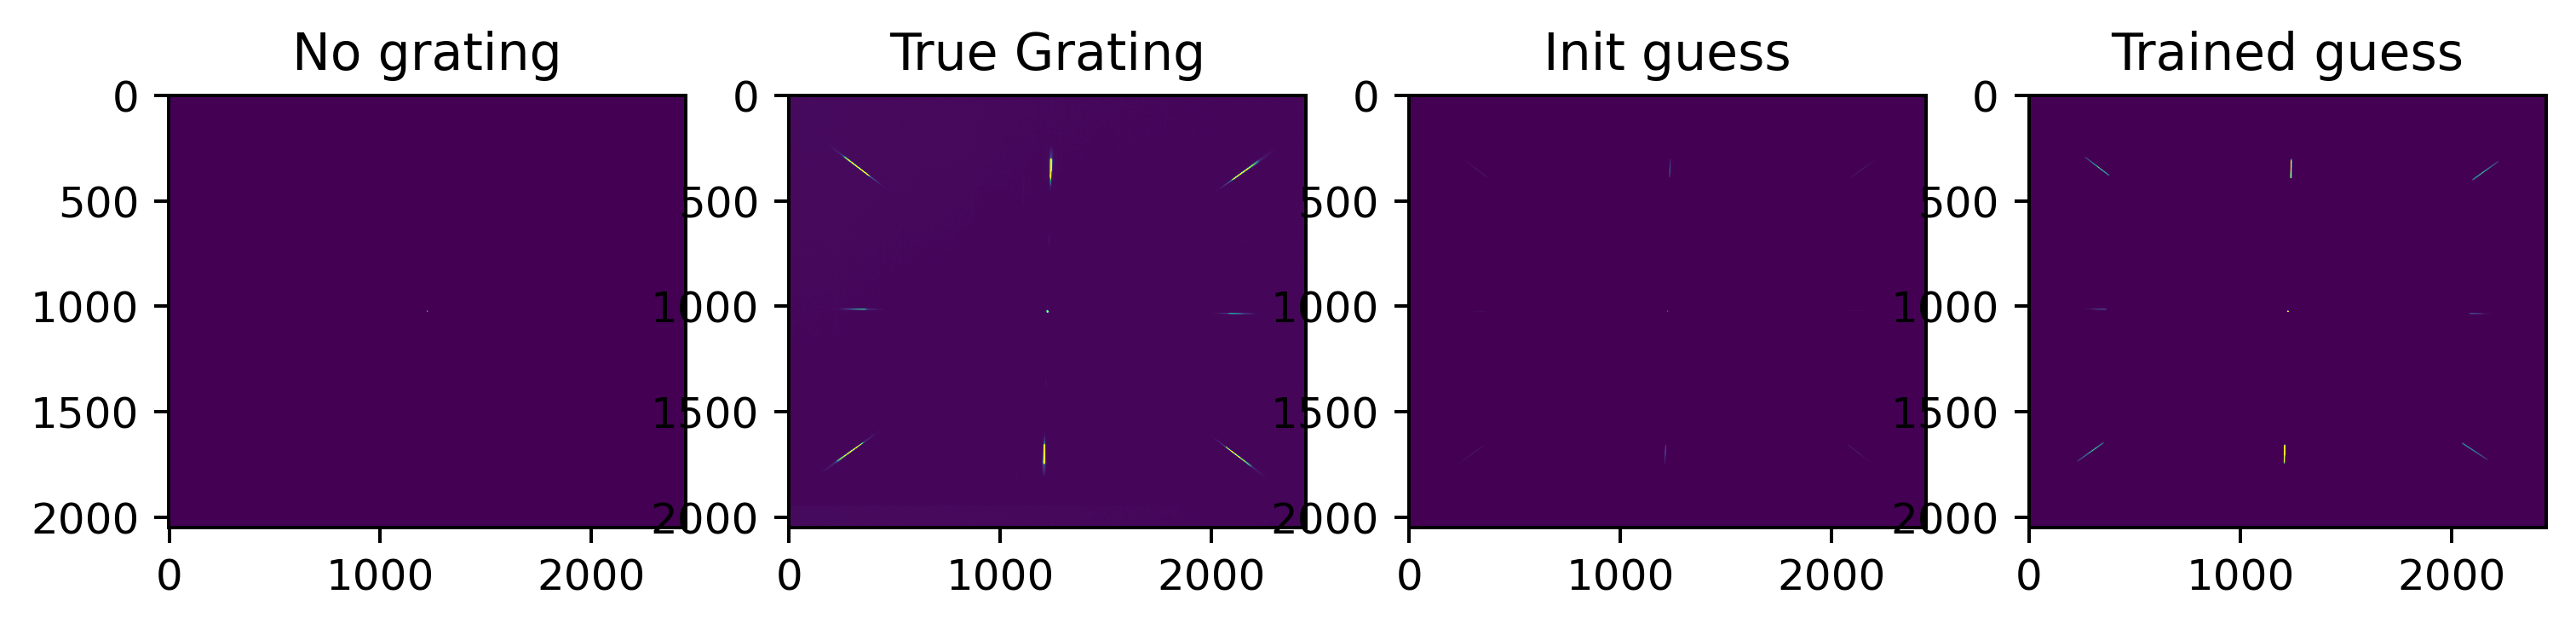

In [41]:
fig,ax = plt.subplots(1,4,figsize=(10,5),dpi=360)
ax[0].imshow(nograting_cube[0,11].cpu().detach().numpy(),vmax=0.1); ax[0].set_title('No grating')
ax[1].imshow(torch.sum(grating_cube[0,a[0]:a[1]],dim=0).cpu().detach().numpy(),vmax=0.1); ax[1].set_title('True Grating')
ax[2].imshow(torch.sum(init_guess[0],dim=0).cpu().detach().numpy(),vmax=0.1); ax[2].set_title('Init guess')
ax[3].imshow(torch.sum(yhat[0],dim=0).cpu().detach().numpy(),vmax=0.1); ax[3].set_title('Trained guess')

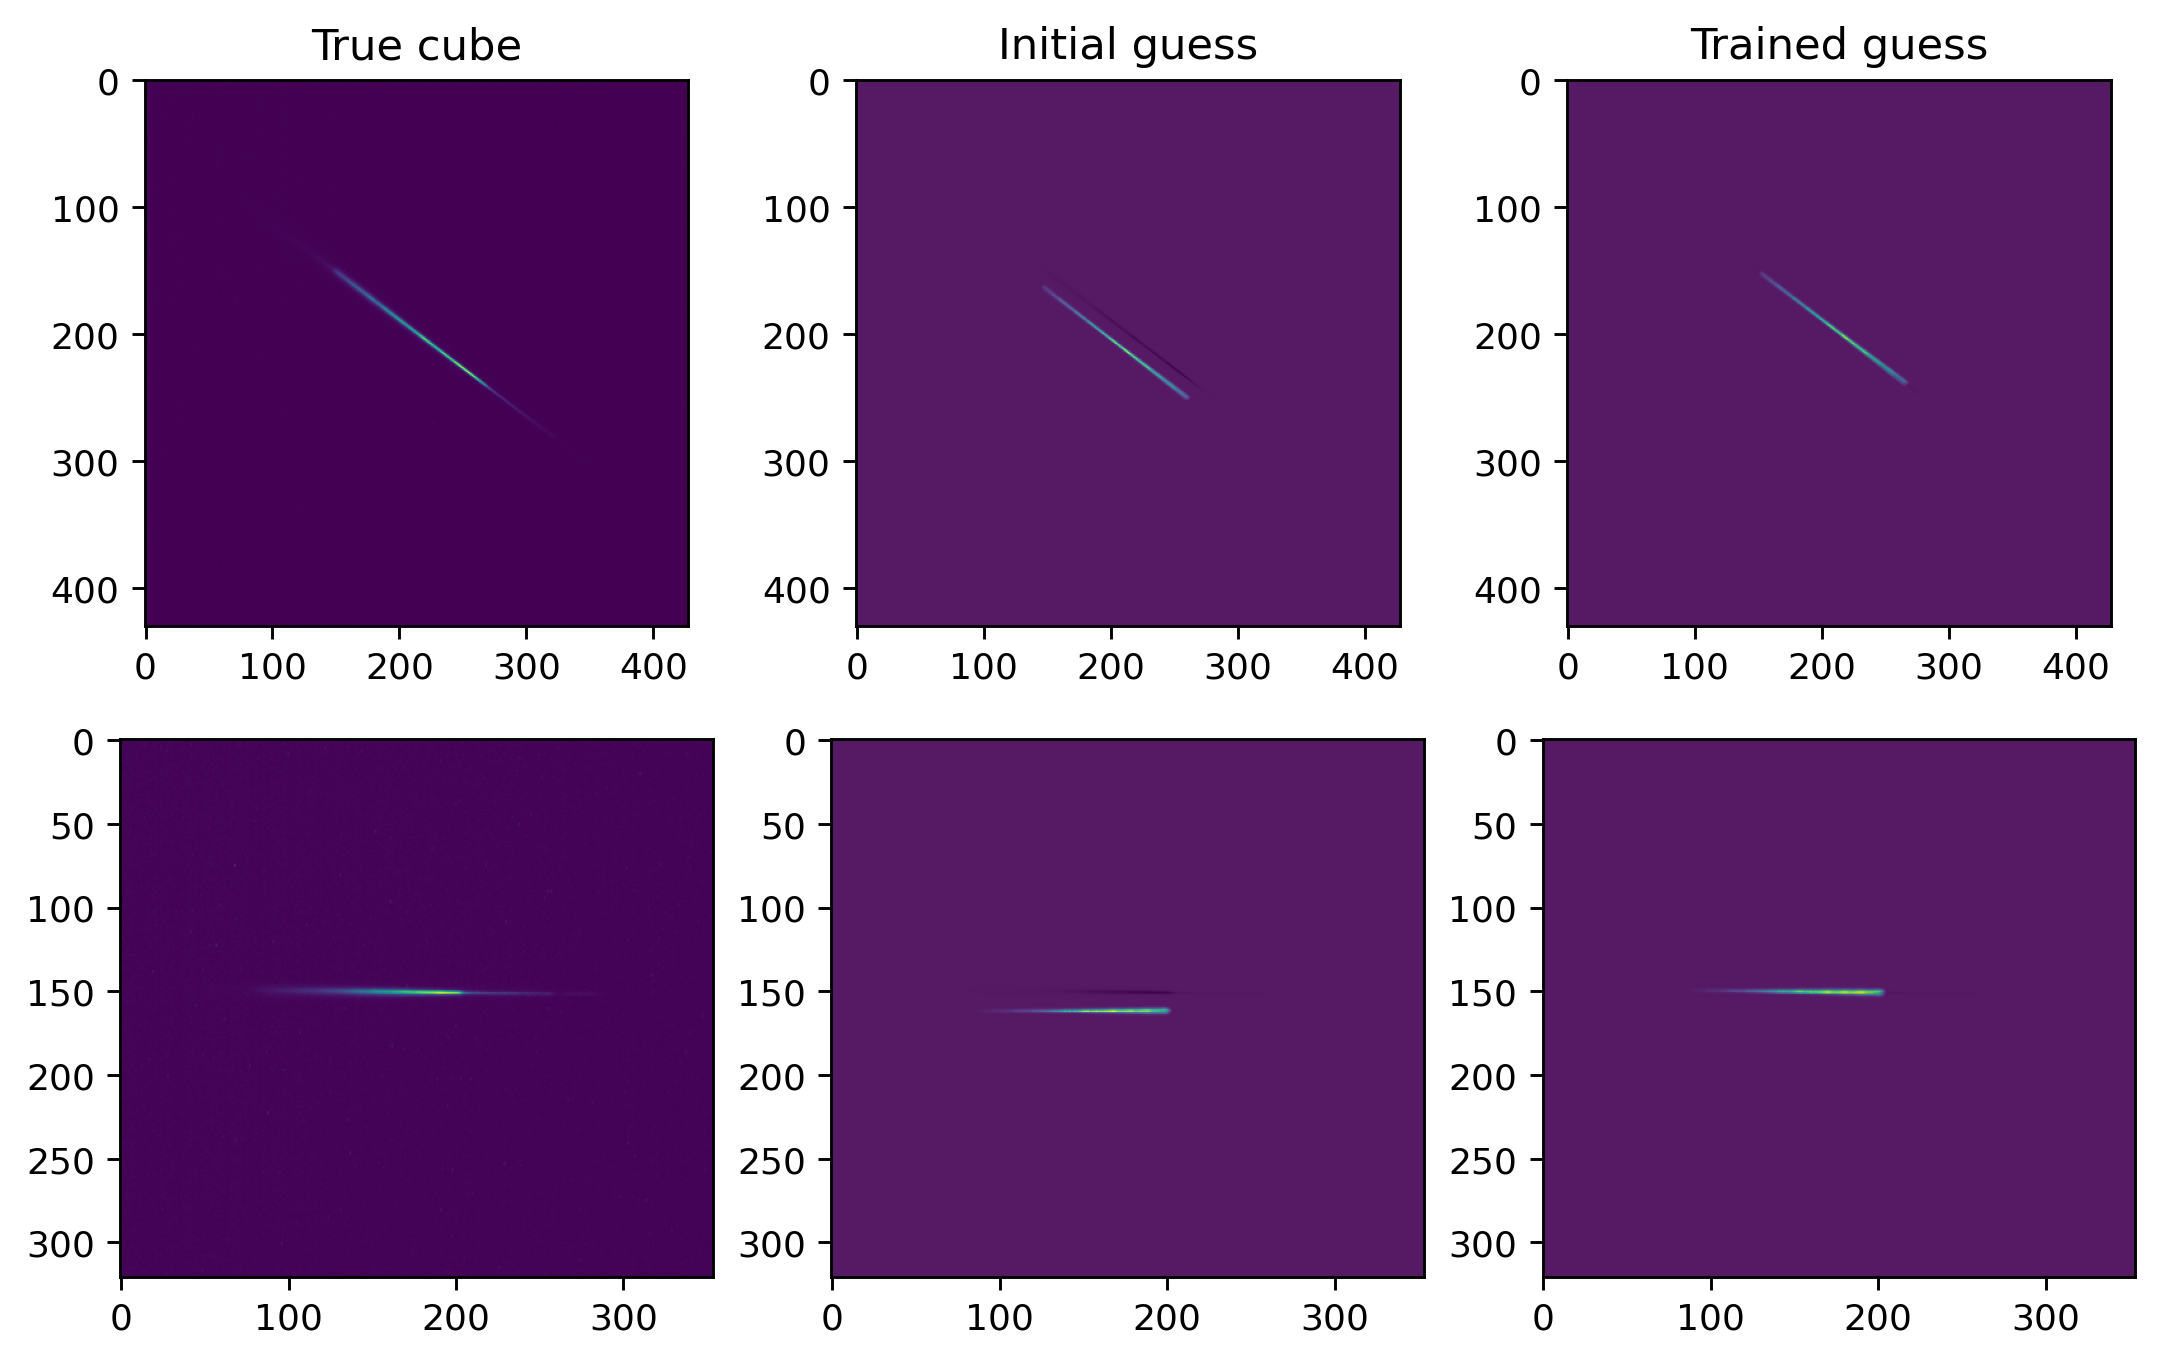

In [42]:


b1,b2 = pos[0,0]#[1600,1800]
b3,b4 = pos[0,1]#[200,400]

fig,ax = plt.subplots(2,3,figsize=(10,6),dpi=260)

vmax,vmin = torch.sum(grating_cube[0,a[0]:a[1],b1:b2,b3:b4],dim=0).max(), torch.sum(grating_cube[0,a[0]:a[1],b1:b2,b3:b4],dim=0).min()


ax[0,0].imshow(torch.sum(grating_cube[0,a[0]:a[1],b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,0].set_title('True cube')
ax[0,1].imshow(torch.sum(init_guess[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,1].set_title('Initial guess')
ax[0,1].imshow(torch.sum(grating_cube[0,a[0]:a[1],b1:b2,b3:b4],dim=0).cpu().detach().numpy(),cmap='Greys',alpha=0.1)
ax[0,2].imshow(torch.sum(yhat[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,2].set_title('Trained guess')
ax[0,2].imshow(torch.sum(grating_cube[0,a[0]:a[1],b1:b2,b3:b4],dim=0).cpu().detach().numpy(),cmap='Greys',alpha=0.1)


a1,a2 = pos[3,0]
a3,a4 = pos[3,1]

vmax,vmin = torch.sum(grating_cube[0,a[0]:a[1],a1:a2,a3:a4],dim=0).max(),torch.sum(grating_cube[0,a[0]:a[1],a1:a2,a3:a4],dim=0).min()


ax[1,0].imshow(torch.sum(grating_cube[0,a[0]:a[1],a1:a2,a3:a4],dim=0).cpu().detach().numpy())
ax[1,1].imshow(torch.sum(init_guess[0,:,a1:a2,a3:a4],dim=0).cpu().detach().numpy())
ax[1,1].imshow(torch.sum(grating_cube[0,a[0]:a[1],a1:a2,a3:a4],dim=0).cpu().detach().numpy(),cmap='Greys',alpha=0.1)
ax[1,2].imshow(torch.sum(yhat[0,:,a1:a2,a3:a4],dim=0).cpu().detach().numpy())
ax[1,2].imshow(torch.sum(grating_cube[0,a[0]:a[1],a1:a2,a3:a4],dim=0).cpu().detach().numpy(),cmap='Greys',alpha=0.1)


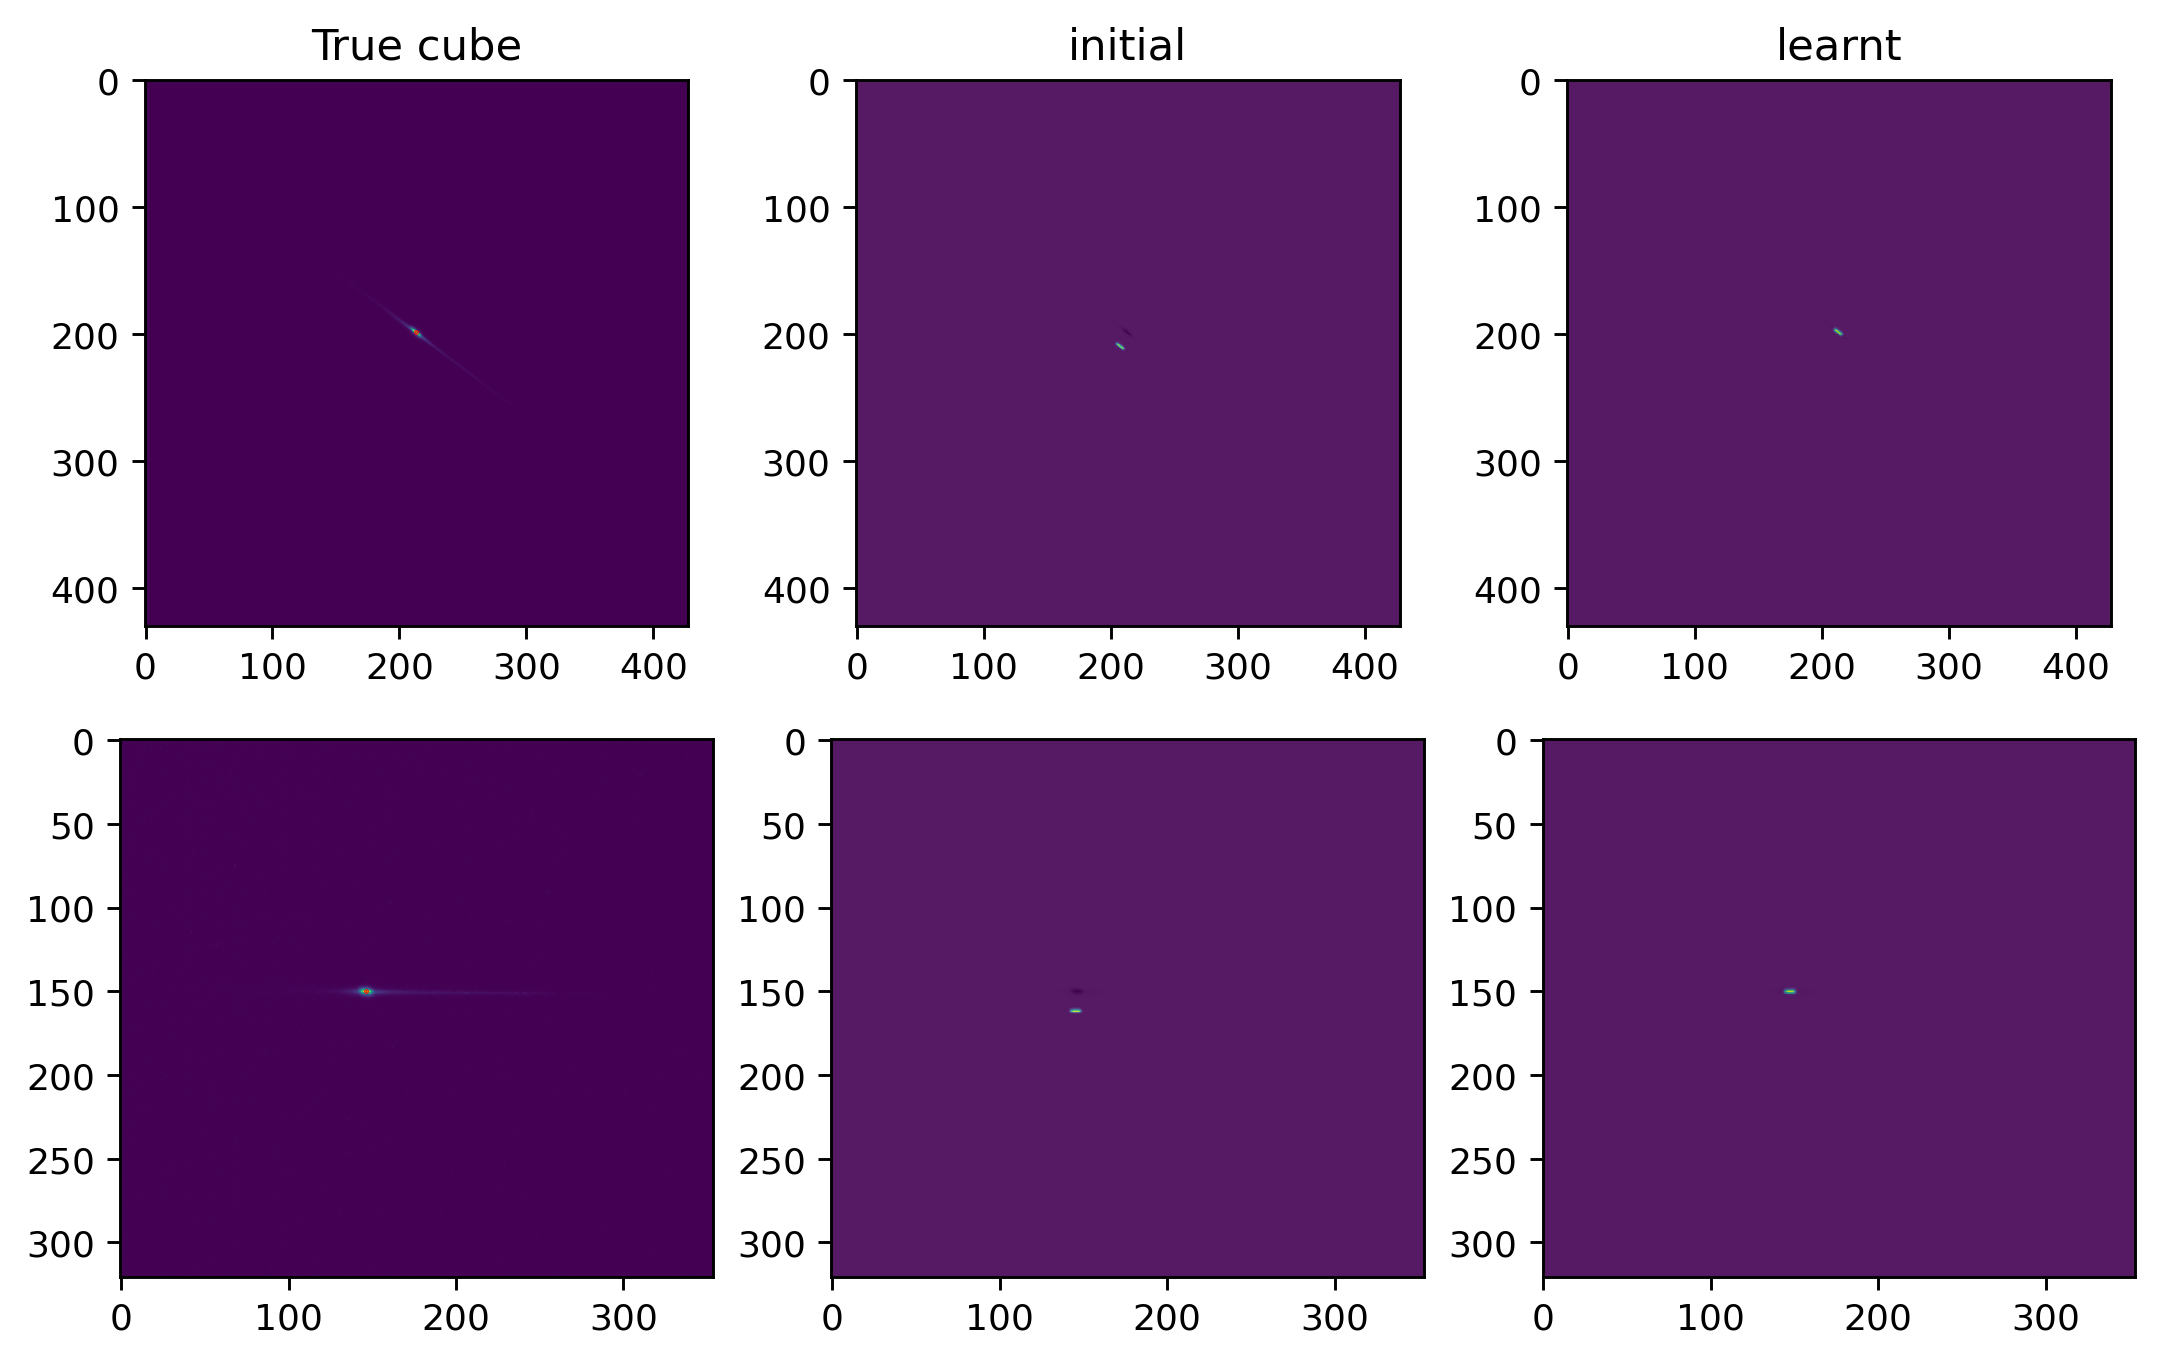

In [59]:
wl = 10

b1,b2 = pos[0,0]#[1600,1800]
b3,b4 = pos[0,1]

CoMs = loss_fn2.calculate_center_of_mass(grating_cube[0], region = pos[0]).cpu()

fig,ax = plt.subplots(2,3,figsize=(10,6),dpi=260)

ax[0,0].set_title('True cube')
ax[0,1].set_title('initial')
ax[0,2].set_title('learnt')

ax[0,0].imshow(grating_cube[:,a[0]:a[1]][0,wl,b1:b2,b3:b4].cpu().detach().numpy())
ax[0,0].scatter(CoMs[wl,1],CoMs[wl,0],c='r',s=0.1)
ax[0,1].imshow(init_guess[0,wl,b1:b2,b3:b4].cpu().detach().numpy())
ax[0,1].imshow(grating_cube[:,a[0]:a[1]][0,wl,b1:b2,b3:b4].cpu().detach().numpy(),cmap='Greys',alpha=0.1)
ax[0,2].imshow(yhat[0,wl,b1:b2,b3:b4].cpu().detach().numpy())
ax[0,2].imshow(grating_cube[:,a[0]:a[1]][0,wl,b1:b2,b3:b4].cpu().detach().numpy(),cmap='Greys',alpha=0.1)


a1,a2 = pos[3,0]#[1600,1800]
a3,a4 = pos[3,1]

CoMs = loss_fn2.calculate_center_of_mass(grating_cube[0], region = pos[3]).cpu()

ax[1,0].imshow(grating_cube[:,a[0]:a[1]][0,wl,a1:a2,a3:a4].cpu().detach().numpy())
ax[1,0].scatter(CoMs[wl,1],CoMs[wl,0],c='r',s=0.1)
ax[1,1].imshow(init_guess[0,wl,a1:a2,a3:a4].cpu().detach().numpy())
ax[1,1].imshow(grating_cube[:,a[0]:a[1]][0,wl,a1:a2,a3:a4].cpu().detach().numpy(),cmap='Greys',alpha=0.1)
ax[1,2].imshow(yhat[0,wl,a1:a2,a3:a4].cpu().detach().numpy())
ax[1,2].imshow(grating_cube[:,a[0]:a[1]][0,wl,a1:a2,a3:a4].cpu().detach().numpy(),cmap='Greys',alpha=0.1)



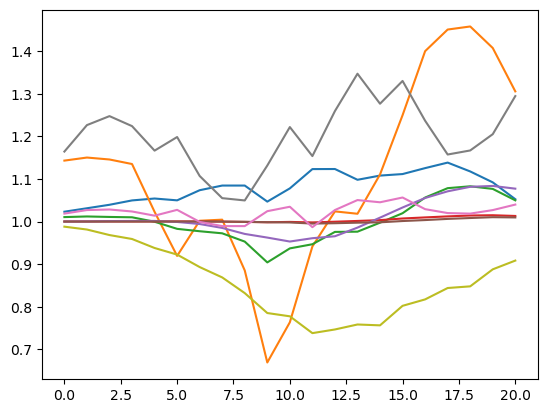

In [62]:
plt.plot(model.grating_spectrum.detach().cpu().T);

In [64]:
yhat_affine = yhat.clone()

## Now that the kernel is in the right position spatially, we make the whole thing trainable.

In [82]:
padding = 4


fine_model = KernelLearner(kernel=affine_kernel.clone(), padding=padding).to(device) 

lr = 5e-4
epochs = 2000

optimizer = torch.optim.Adam(fine_model.parameters(), lr=lr)

init_guess = fine_model(nograting_cube[:,a[0]:a[1]])

loss_fn = torch.nn.MSELoss()

loss = loss_fn(init_guess,grating_cube[:,a[0]:a[1]])
print(loss)

tensor(3.5815e-07, device='cuda:0', grad_fn=<MseLossBackward0>)


In [83]:
history2 = {} # Collects per-epoch loss and acc like Keras' fit().
history2['mse'] = []





start_time_sec = time.time()

for epoch in range(1, epochs+1):
    # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
    start_time_sec = time.time()
    model.train()
    num_train_examples = 1

    optimizer.zero_grad()
    
    yhat = fine_model(nograting_cube[:,a[0]:a[1]])
    loss = loss_fn(yhat, grating_cube[:,a[0]:a[1]])

    loss.backward()
    optimizer.step()

    train_loss         = loss.data.item() * grating_cube.size(0)
    


    end_time_sec       = time.time()
    total_time_sec     = end_time_sec - start_time_sec

    print(f'Epoch {epoch}/{epochs}:, train loss: {train_loss:5.5g}, epoch time: {total_time_sec:5.5g}',end='\r')


    history2['mse'].append(train_loss)


    
# with open('model_results.txt', 'a') as file:
#     file.write(f'model={model_name}, lr = {lr}, epochs = {epochs}\n')
#     file.write(f'epoch time: {total_time_sec}\n')
#     file.write(f'history: {history}\n')

Text(0.5, 0, 'Epochs')

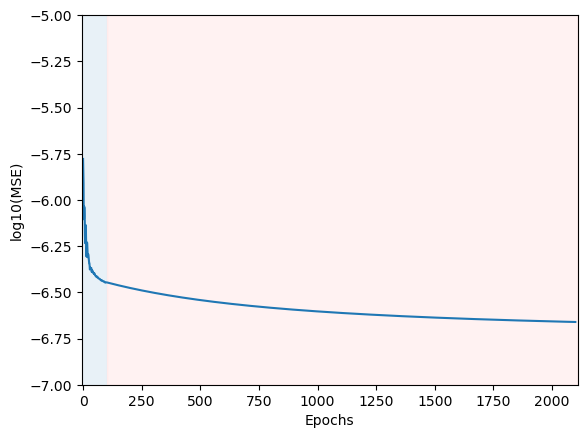

In [95]:
plt.plot(np.log10(history['mse']+history2['mse']))
plt.fill_betweenx(np.linspace(-7,1,100),-1,100,alpha=0.1)
plt.fill_betweenx(np.linspace(-7,1,100),100,2109,color='r',alpha=0.05)

plt.xlim([-5,2110])
plt.ylim([-7,-5])
plt.ylabel('log10(MSE)')
plt.xlabel('Epochs')

In [85]:
trained_kernel = fine_model.fill_kernel()
init_kernel = affine_kernel.clone()
init_guess = fwd.disperser.disperse_all_orders(nograting_cube[:,a[0]:a[1]],affine_kernel[:,a[0]:a[1]])

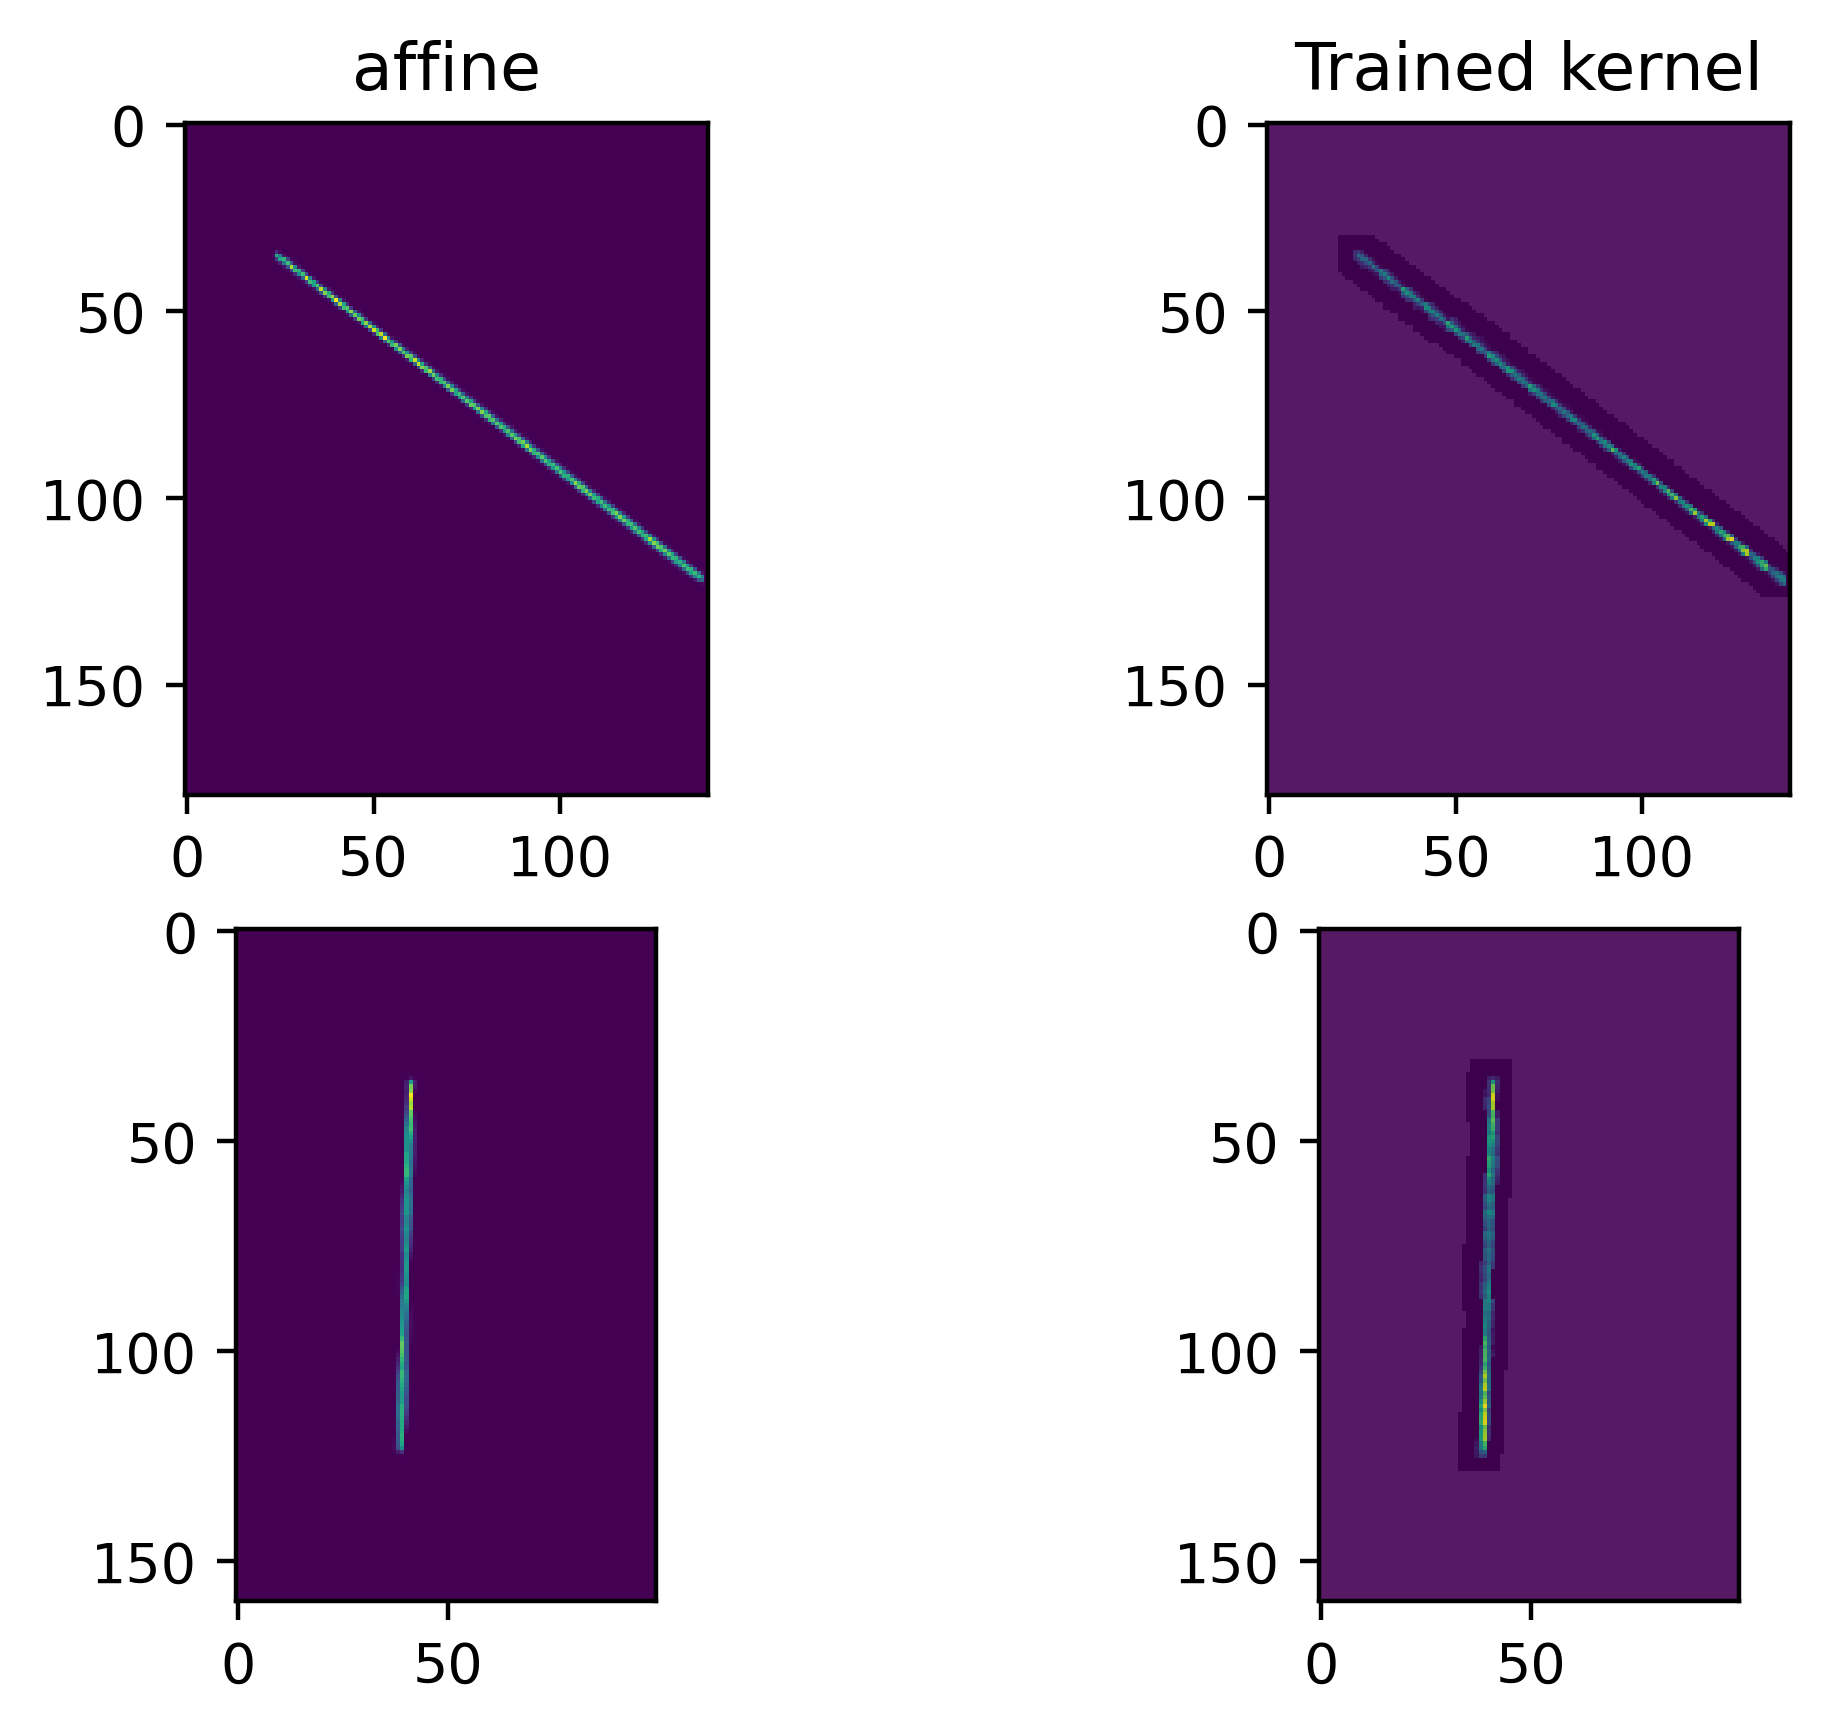

In [86]:
bx = [260,440]
by = [240,380]

fig,ax = plt.subplots(2,2,dpi=400)
ax[0,0].imshow(torch.sum(init_kernel[0,a[0]:a[1]],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[0,0].set_title('affine')
# ax[1].imshow(torch.sum(weiner_kernel[0],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[1].set_title('Weiner kernel')
ax[0,1].imshow(torch.sum(trained_kernel[0],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy()); ax[0,1].set_title('Trained kernel')
ax[0,1].imshow((torch.sum(fine_model.locations,dim=0)>0)[bx[0]:bx[1],by[0]:by[1]],alpha=0.1,cmap='Greys'); 
# ax[0,3].imshow((np.sum(model.locations,axis=0)>0)[bx[0]:bx[1],by[0]:by[1]]); ax[0,3].set_title('Trainable region')

bx = [270,430]
by = [1200,1300]
ax[1,0].imshow(torch.sum(init_kernel[0,a[0]:a[1]],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy());
ax[1,1].imshow(torch.sum(trained_kernel[0],dim=0)[bx[0]:bx[1],by[0]:by[1]].cpu().detach().numpy());
ax[1,1].imshow((torch.sum(fine_model.locations,dim=0)>0)[bx[0]:bx[1],by[0]:by[1]],alpha=0.1,cmap='Greys'); 

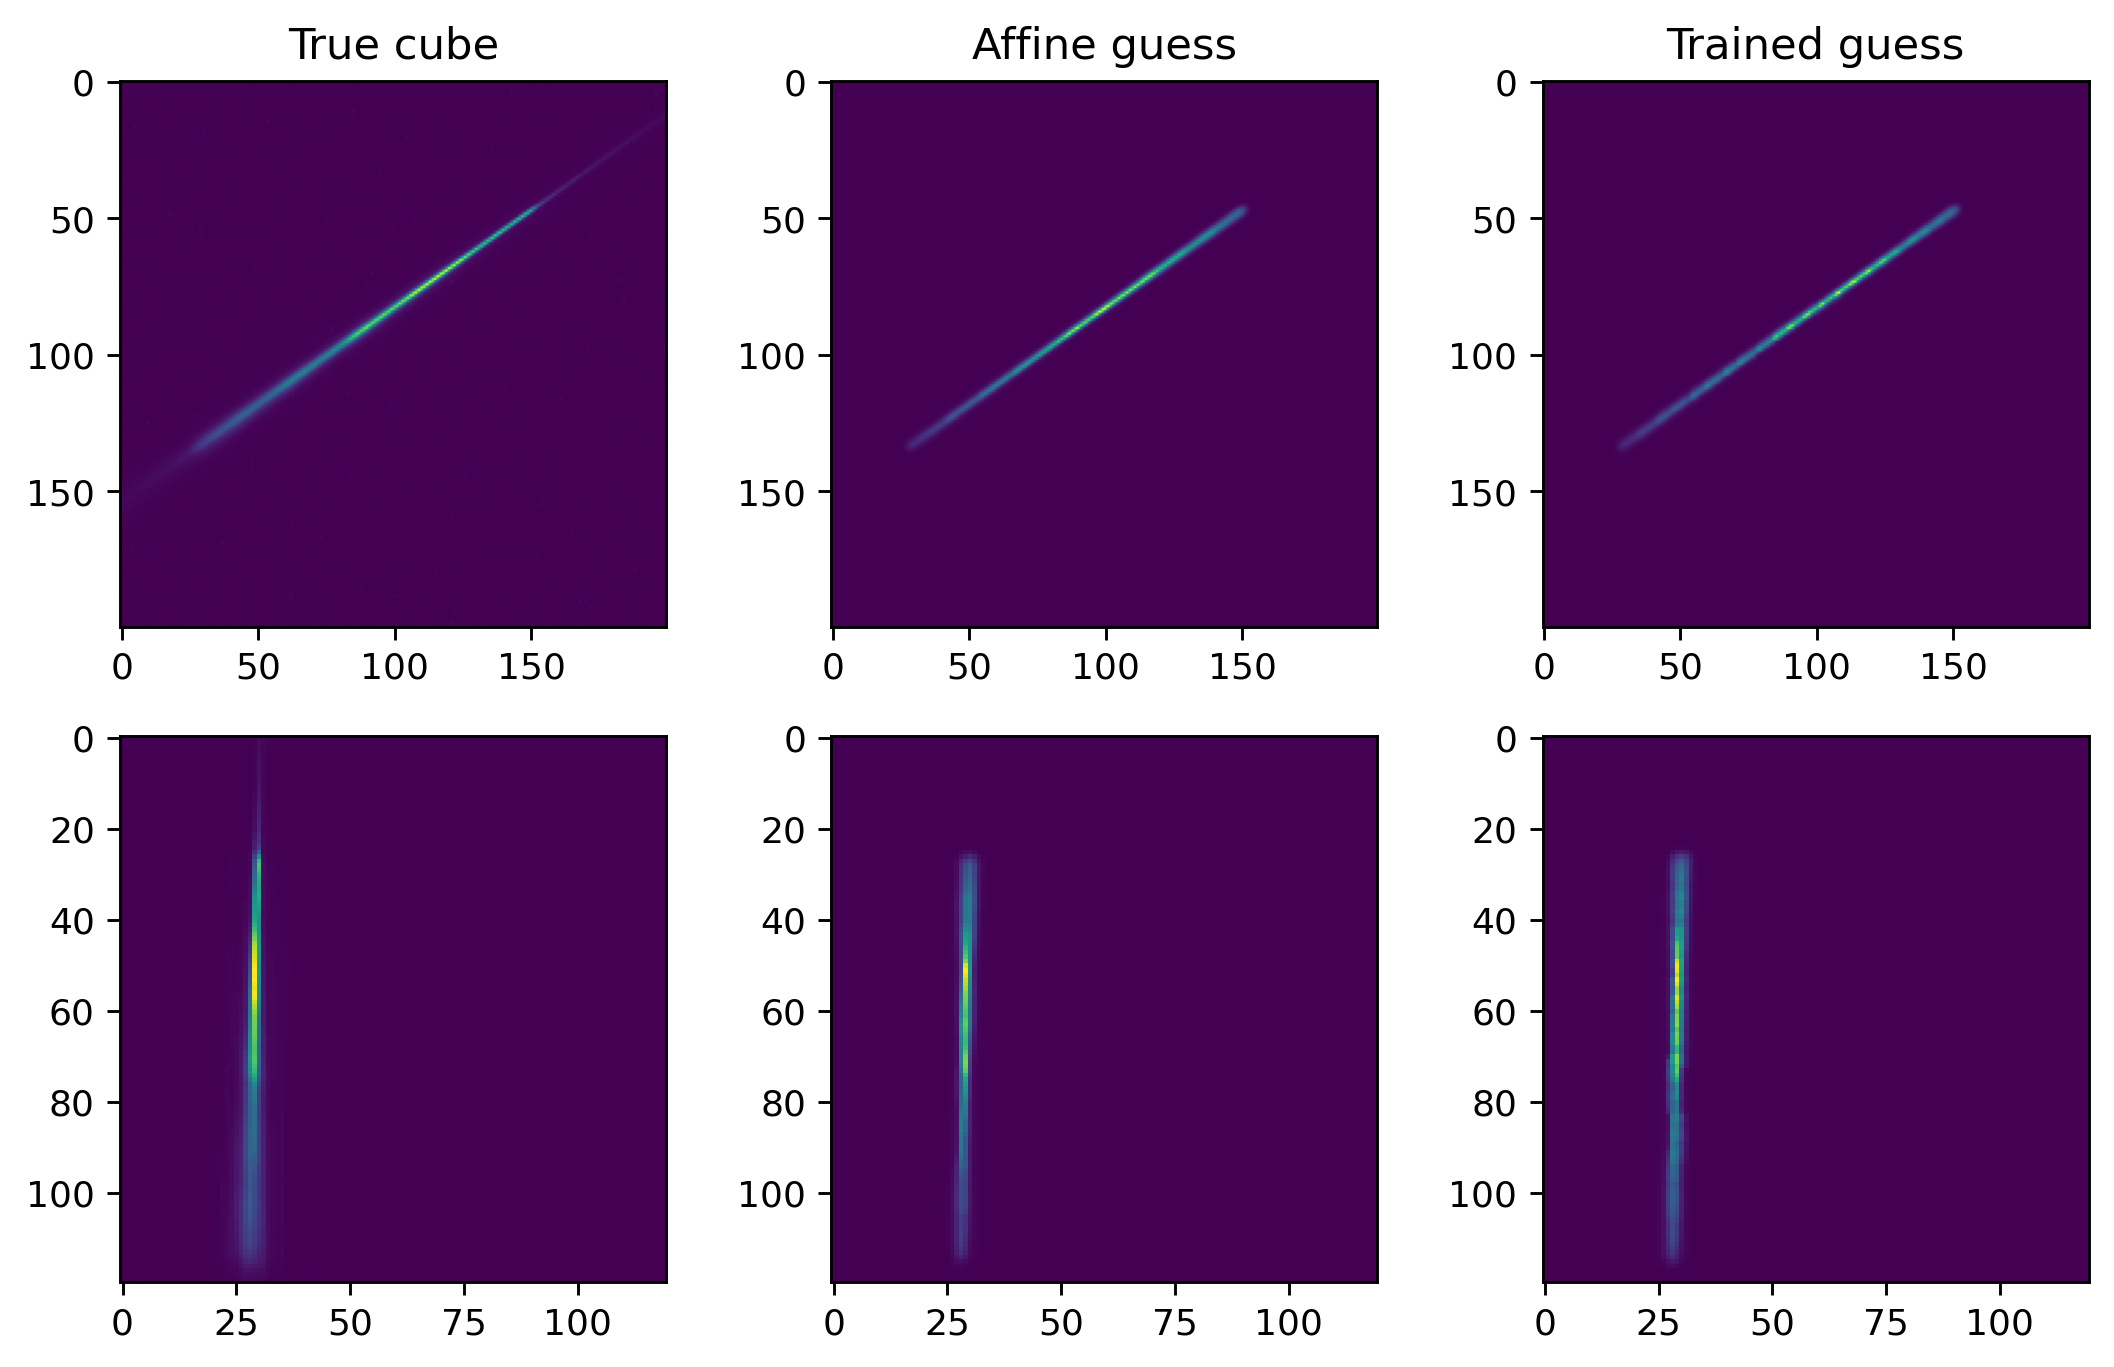

In [87]:
b1,b2 = [1600,1800]
b3,b4 = [200,400]

fig,ax = plt.subplots(2,3,figsize=(10,6),dpi=260)

vmax,vmin = torch.sum(grating_cube[0,a[0]:a[1],b1:b2,b3:b4],dim=0).max(), torch.sum(grating_cube[0,a[0]:a[1],b1:b2,b3:b4],dim=0).min()


ax[0,0].imshow(torch.sum(grating_cube[0,a[0]:a[1],b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,0].set_title('True cube')
ax[0,1].imshow(torch.sum(init_guess[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,1].set_title('Affine guess')
ax[0,2].imshow(torch.sum(yhat[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,2].set_title('Trained guess')

a1,a2 = [1630,1750]
a3,a4 = [1180,1300]

vmax,vmin = torch.sum(grating_cube[0,a[0]:a[1],a1:a2,a3:a4],dim=0).max(),torch.sum(grating_cube[0,a[0]:a[1],a1:a2,a3:a4],dim=0).min()


ax[1,0].imshow(torch.sum(grating_cube[0,a[0]:a[1],a1:a2,a3:a4],dim=0).cpu().detach().numpy())
ax[1,1].imshow(torch.sum(init_guess[0,:,a1:a2,a3:a4],dim=0).cpu().detach().numpy())
ax[1,2].imshow(torch.sum(yhat[0,:,a1:a2,a3:a4],dim=0).cpu().detach().numpy())

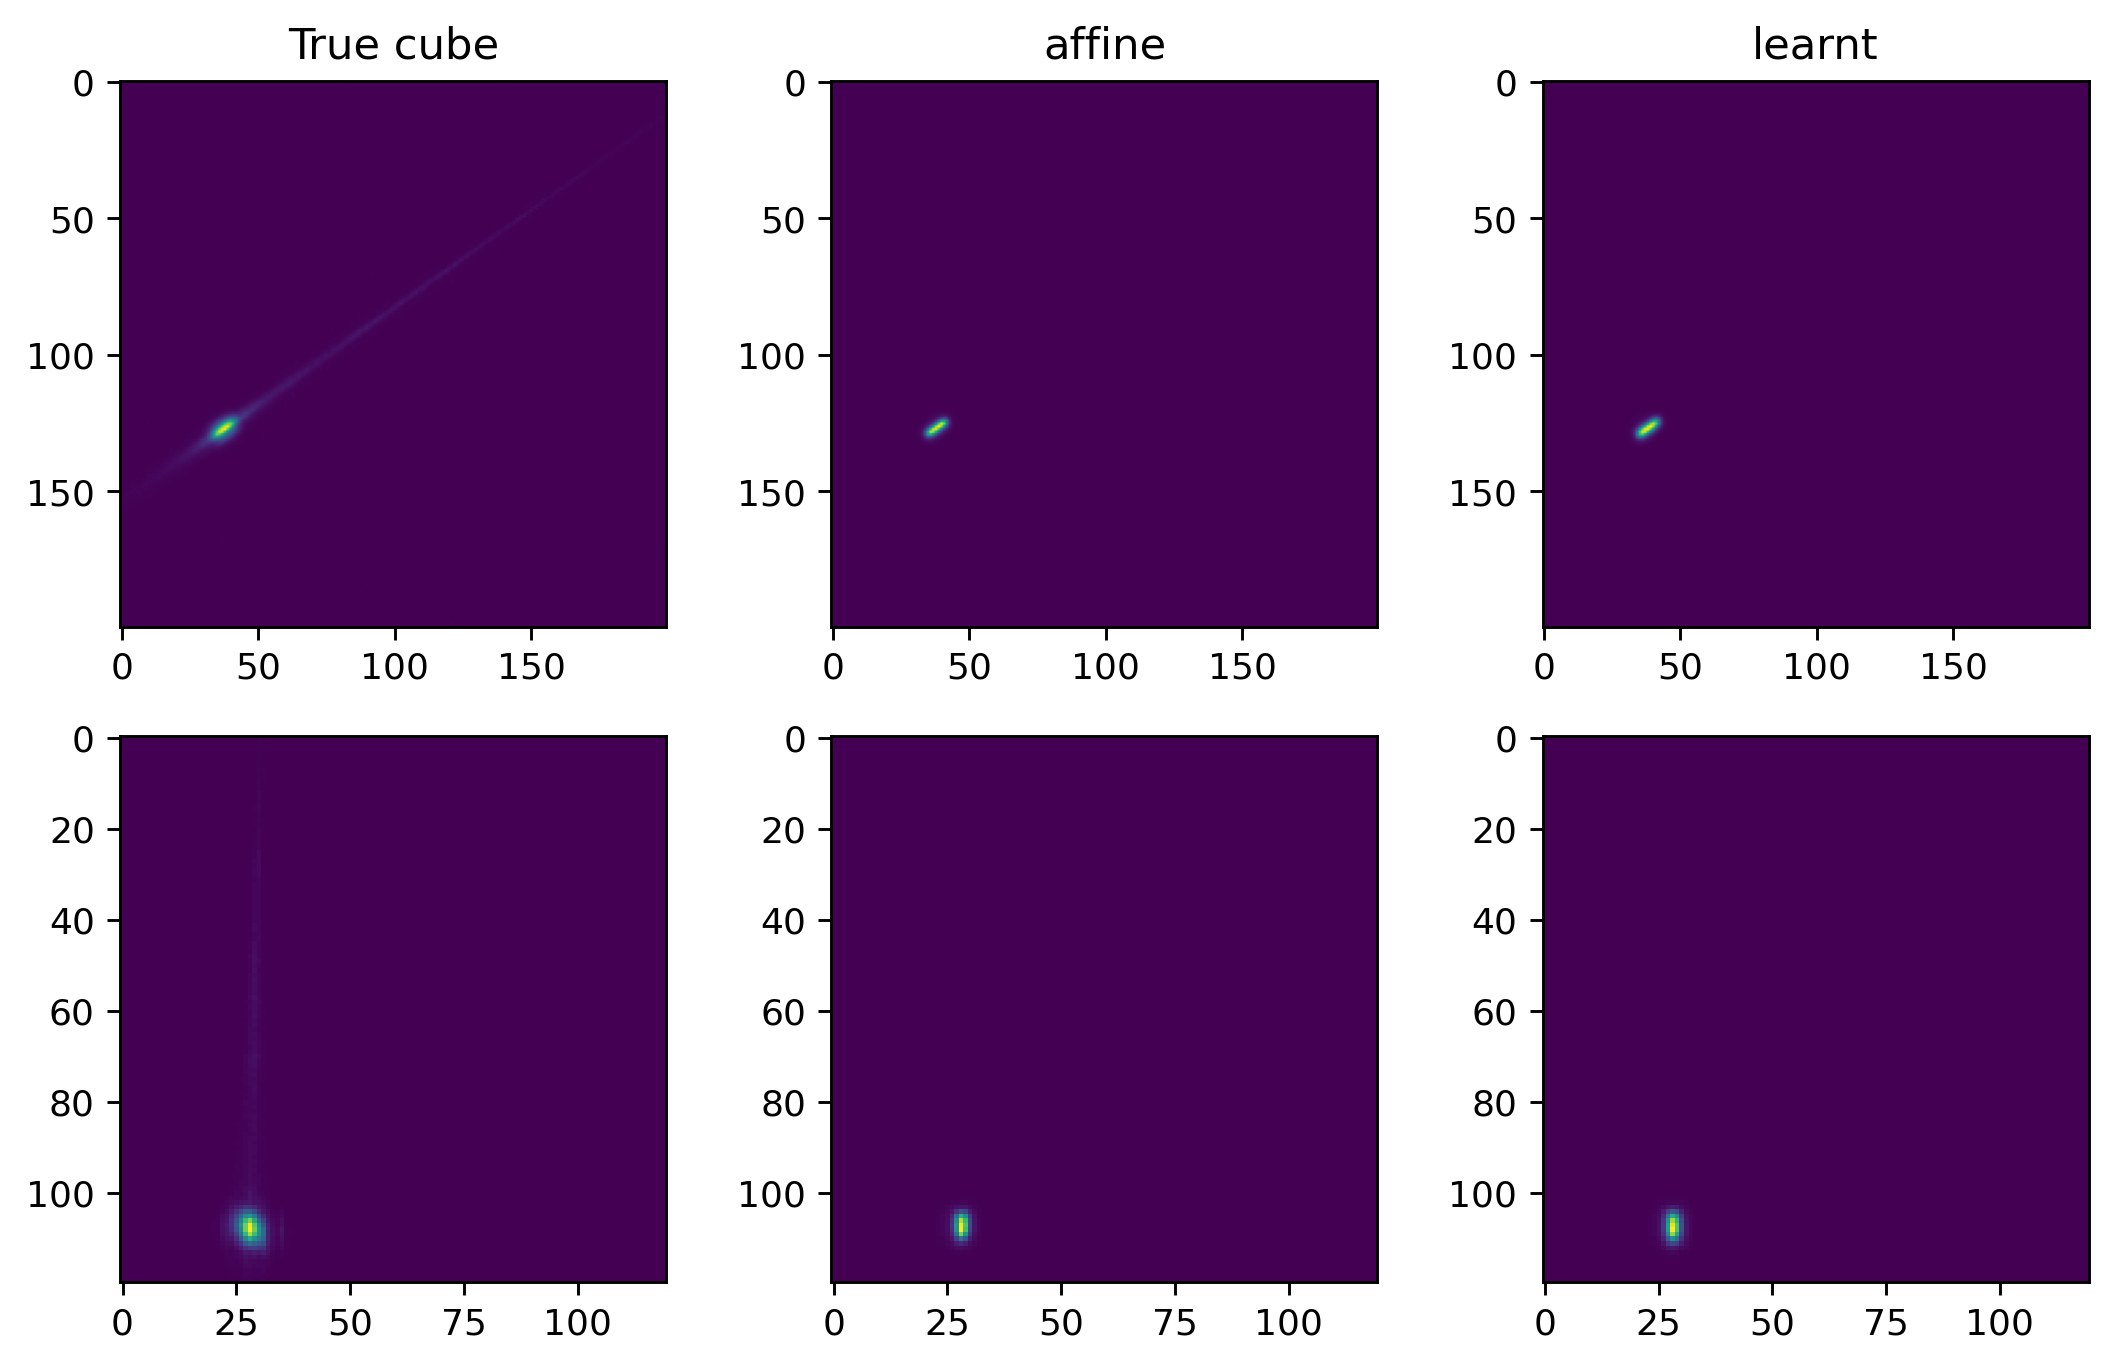

In [88]:
wl = 1

b1,b2 = [1600,1800]
b3,b4 = [200,400]



fig,ax = plt.subplots(2,3,figsize=(10,6),dpi=260)

ax[0,0].set_title('True cube')
ax[0,1].set_title('affine')
ax[0,2].set_title('learnt')

ax[0,0].imshow(grating_cube[:,a[0]:a[1]][0,wl,b1:b2,b3:b4].cpu().detach().numpy())
ax[0,1].imshow(init_guess[0,wl,b1:b2,b3:b4].cpu().detach().numpy())
ax[0,2].imshow(yhat[0,wl,b1:b2,b3:b4].cpu().detach().numpy())

a1,a2 = [1630,1750]
a3,a4 = [1180,1300]

ax[1,0].imshow(grating_cube[:,a[0]:a[1]][0,wl,a1:a2,a3:a4].cpu().detach().numpy())
ax[1,1].imshow(init_guess[0,wl,a1:a2,a3:a4].cpu().detach().numpy())
ax[1,2].imshow(yhat[0,wl,a1:a2,a3:a4].cpu().detach().numpy())

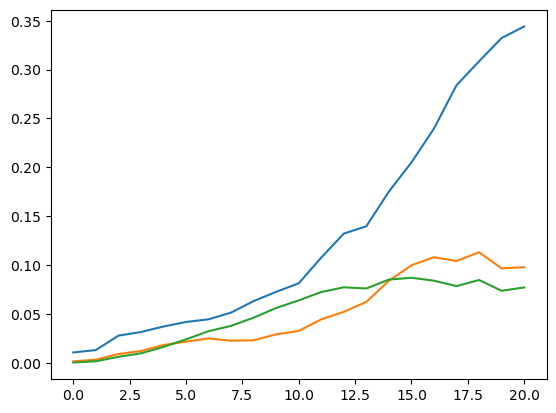

In [89]:
bla = torch.sum(grating_cube,dim=(0,1)).argmax()
plt.plot(grating_cube.view(1,21,2048*2448)[0,...,bla].cpu())
plt.plot(yhat.view(1,21,2048*2448)[0,...,bla].detach().cpu())
plt.plot(yhat_affine.view(1,21,2048*2448)[0,...,bla].detach().cpu())


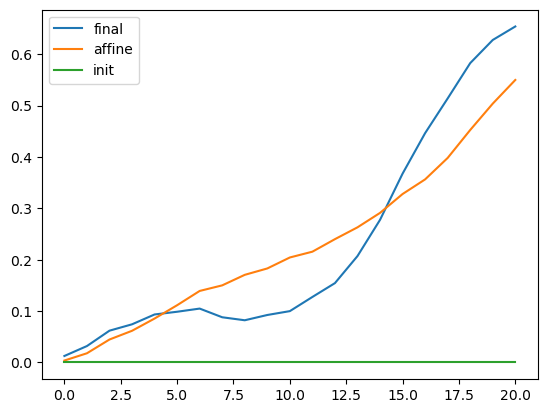

In [90]:
bla = torch.sum(trained_kernel,dim=(0,1)).argmax()

plt.plot(trained_kernel.view(1,21,2048*2448)[0,...,bla].detach().cpu())
plt.plot(affine_kernel.view(1,21,2048*2448)[0,...,bla].detach().cpu())
plt.plot(kernel.view(1,21,2048*2448)[0,...,bla].detach().cpu())

plt.legend(['final','affine','init'])

In [2]:
torch.save(trained_kernel, '../kernel.pt')

### We can test our new kernel on some of the cubes without a mask...

In [92]:
grating_cube, _, _ = hlp.create_bs_data(desired_channels=21,kernel=kernel,fts_dir = '20230628_2gratings_data_1500us_talbot_0', cube_dir = '20230628_2gratings_analysis_1500us_talbot_0', interp_type='average',device=device)
nograting_cube, _, _ = hlp.create_bs_data(desired_channels=21,kernel=kernel,fts_dir = '20230628_data_300us_talbot_0/', cube_dir = '20230628_analysis_300us_talbot_0/', interp_type='average',device=device) 

collecting the undispersed cube and spectra.
collecting the undispersed cube and spectra.


In [97]:
yhat = fwd.disperser.disperse_all_orders(nograting_cube[:,a[0]:a[1]],trained_kernel[:,a[0]:a[1]])

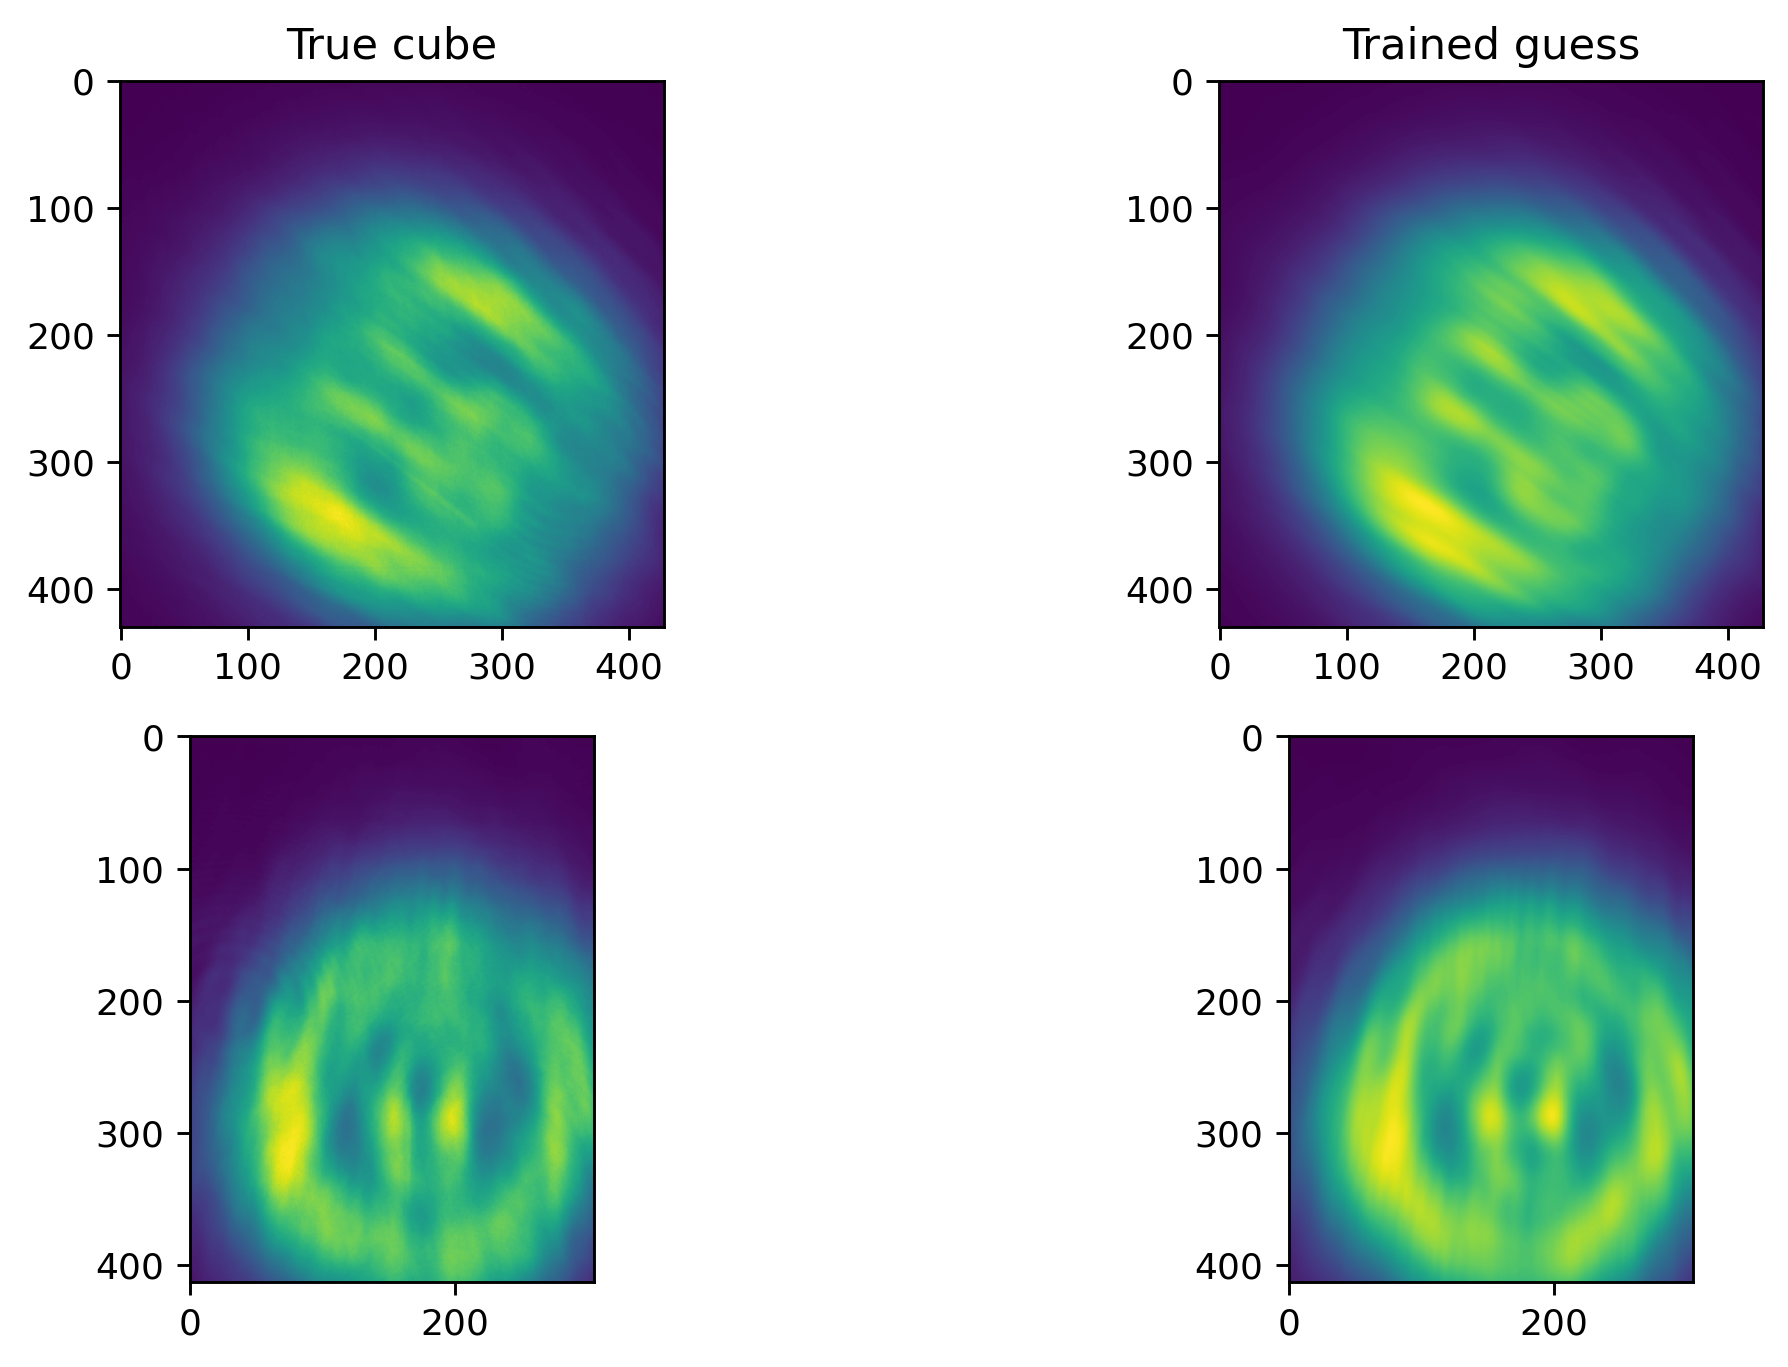

In [100]:
b1,b2 = pos[0,0]#[1600,1800]
b3,b4 = pos[0,1]#[200,400]

fig,ax = plt.subplots(2,2,figsize=(10,6),dpi=260)

vmax,vmin = torch.sum(grating_cube[0,a[0]:a[1],b1:b2,b3:b4],dim=0).max(), torch.sum(grating_cube[0,a[0]:a[1],b1:b2,b3:b4],dim=0).min()


ax[0,0].imshow(torch.sum(grating_cube[0,a[0]:a[1],b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,0].set_title('True cube')
ax[0,1].imshow(torch.sum(yhat[0,:,b1:b2,b3:b4],dim=0).cpu().detach().numpy()); ax[0,1].set_title('Trained guess')


a1,a2 = pos[7,0]
a3,a4 = pos[7,1]

vmax,vmin = torch.sum(grating_cube[0,a[0]:a[1],a1:a2,a3:a4],dim=0).max(),torch.sum(grating_cube[0,a[0]:a[1],a1:a2,a3:a4],dim=0).min()


ax[1,0].imshow(torch.sum(grating_cube[0,a[0]:a[1],a1:a2,a3:a4],dim=0).cpu().detach().numpy())
ax[1,1].imshow(torch.sum(yhat[0,:,a1:a2,a3:a4],dim=0).cpu().detach().numpy())
